<a href="https://colab.research.google.com/github/p-owens/MAI/blob/main/MAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [3]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
        print("Training Accuracy: ", self.acc)
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving x_val.csv to x_val.csv
Saving y_val.csv to y_val.csv
User uploaded file "x_val.csv" with length 11708616 bytes
User uploaded file "y_val.csv" with length 5590212 bytes


In [5]:
#files = uploaded.keys()
#for fn in files:
res = list(uploaded.keys())[1] 
print(res)

print(type(uploaded[res]))

 

y_val.csv
<class 'bytes'>


In [14]:
df0 = pd.read_csv("x_val.csv",
                index_col=False,
                 header=None
                 )
df1 = pd.read_csv("y_val.csv",
                index_col=False,
                 header=None
                 )



In [17]:
x_values = df0.to_numpy()
y_values = df1.to_numpy()

y_values = y_values[:,0]
x_values = x_values[1::2,:]
print(x_values[0:2,:])
print(y_values[0:20])
print(y_values.shape)
print(x_values.shape)
print("\n\n")


"""
x_rows = np.shape(x_values)[1]
print(x_values.shape)
x_values = np.reshape(x_values, (len(y_values), x_rows * 2))
print(x_values.shape)
print(x_values[0,:])
"""

[[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.
  1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
  1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.]]
[1.38589439 1.4471488  0.         1.10415431 1.76300941 1.19643271
 1.8506994  0.         0.         0.         0.         0.
 1.42425867 1.24256777 1.38136267 0.         1.15511596 0.
 1.51584834 1.39263952]
(11972,)
(11972, 44)





'\nx_rows = np.shape(x_values)[1]\nprint(x_values.shape)\nx_values = np.reshape(x_values, (len(y_values), x_rows * 2))\nprint(x_values.shape)\nprint(x_values[0,:])\n'

In [9]:
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size=.1, random_state=0)

#x_val = np.reshape(x_val, (int(np.shape(x_val)[0] * 2), int(np.shape(x_val)[1] / 2)))
#x_train = np.reshape(x_train, (int(np.shape(x_train)[0] * 2), int(np.shape(x_train)[1] / 2)))



In [24]:
inputs = keras.layers.Input(shape=(44,))

x = Dense(88, activation='relu')(inputs)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(88, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out random 25% to prevent overfitting
x = Dense(88, activation='relu')(x)
x = Dropout(0.45)(x) # Drop out random 2% to prevent overfitting
x = Dense(44, activation='linear')(x)
x = Dropout(0.45)(x) # Drop out random 25% to prevent overfitting



predictions = Dense(1, activation='relu')(x)

# we create the model 
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.99, nesterov=True)
# opt = keras.optimizers.Adadelta()

# setup the optimisation strategy
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 88)                3960      
_________________________________________________________________
dropout_12 (Dropout)         (None, 88)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 88)                7832      
_________________________________________________________________
dropout_13 (Dropout)         (None, 88)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 88)                7832      
_________________________________________________________________
dropout_14 (Dropout)         (None, 88)                0   

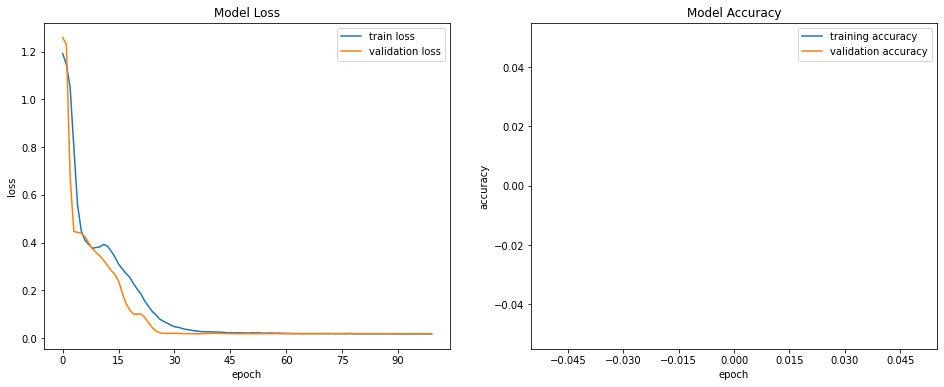

Training Accuracy:  [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [25]:
pltCallBack = PlotLossAccuracy()

# and train
model.fit(x_train, y_train,
          batch_size=4096, epochs=100, 
          validation_data=(x_val, y_val), 
          callbacks=[pltCallBack])

In [ ]:
test_loss = model.evaluate(X_test,y_test)
print("test loss", test_loss)